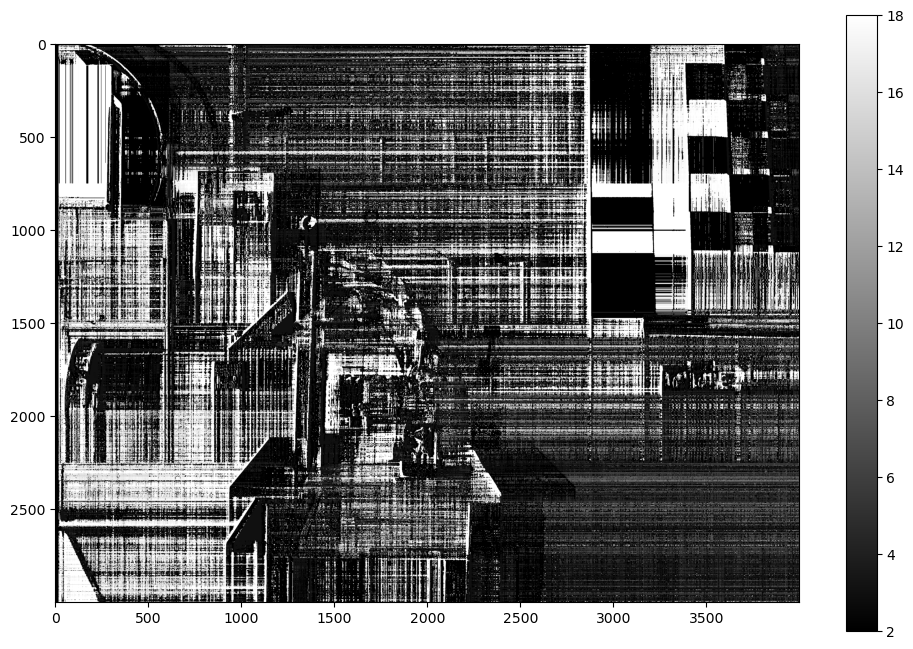

In [2]:
import cv2 as cv
import numpy as np
from matplotlib import pyplot as plt


# Lade die beiden Bilder
imgL = cv.imread('Utils/Images/test/LINKS_V3.png', 0)
imgR = cv.imread('Utils/Images/test/RECHTS_V3.png', 0)

#print(imgL)
 
#imgL = cv.resize(imgL, None, fx=0.48, fy=0.34, interpolation=cv.INTER_CUBIC)
#imgR = cv.resize(imgR, None, fx=0.48, fy=0.34, interpolation=cv.INTER_CUBIC)

window_size = 3
min_disp = 3
nDispFactor = 20
num_disp = 16


stereo = cv.StereoSGBM_create(minDisparity = min_disp,
                              numDisparities = num_disp,
                              blockSize = window_size,
                              P1 = 8 * 3 * window_size**2,
                              P2 = 32 * 3 * window_size**2,
                              disp12MaxDiff = 1,
                              uniquenessRatio = 15,
                              speckleWindowSize = 2,
                              speckleRange = 2,
                              preFilterCap = 63,
                              mode = cv.STEREO_SGBM_MODE_SGBM_3WAY)

#compute
disparity = stereo.compute(imgL,imgR).astype(np.float32) / 16.0

# Normiere die Disparitätswerte auf den Bereich 0–255, damit sie als Bild gespeichert werden können
disparity_normalized = cv.normalize(disparity, None, alpha=0, beta=255, norm_type=cv.NORM_MINMAX)
disparity_normalized = np.uint8(disparity_normalized)

# Speicher die Disparitätskarte im Utils-Ordner
output_path = 'Utils/disparity_map.png'
cv.imwrite(output_path, disparity_normalized)


#Display
plt.figure(figsize=(12, 8))
plt.imshow(disparity, 'gray')
plt.colorbar()
plt.show()

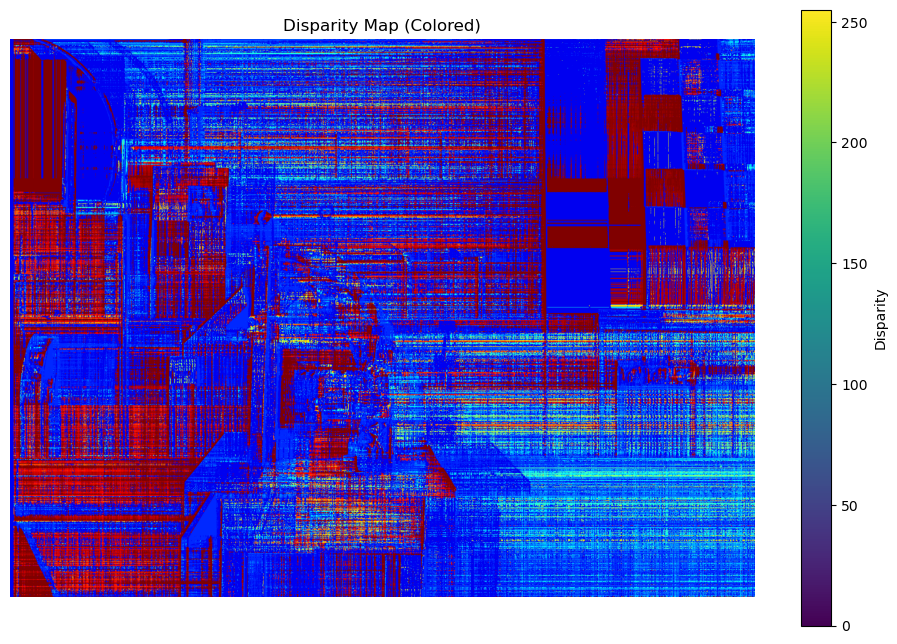

In [9]:
def show_disparity_with_color(disparity_map):
    # Umwandeln der Disparitätskarte in Farbe mit Jet-Colormap
    disparity_color = cv.applyColorMap((disparity_map * 255 / np.max(disparity_map)).astype(np.uint8), cv.COLORMAP_JET)

    # Anzeigen der Disparitätskarte mit Farbe
    plt.figure(figsize=(12, 8))
    plt.imshow(cv.cvtColor(disparity_color, cv.COLOR_BGR2RGB))
    plt.colorbar(label='Disparity')
    plt.title('Disparity Map (Colored)')
    plt.axis('off')
    plt.show()

# Berechnen der Disparitätskarte
disparity_map = stereo.compute(imgL, imgR).astype(np.float32) / 16.0

# Anzeigen der Disparitätskarte mit Farbe
show_disparity_with_color(disparity_map)

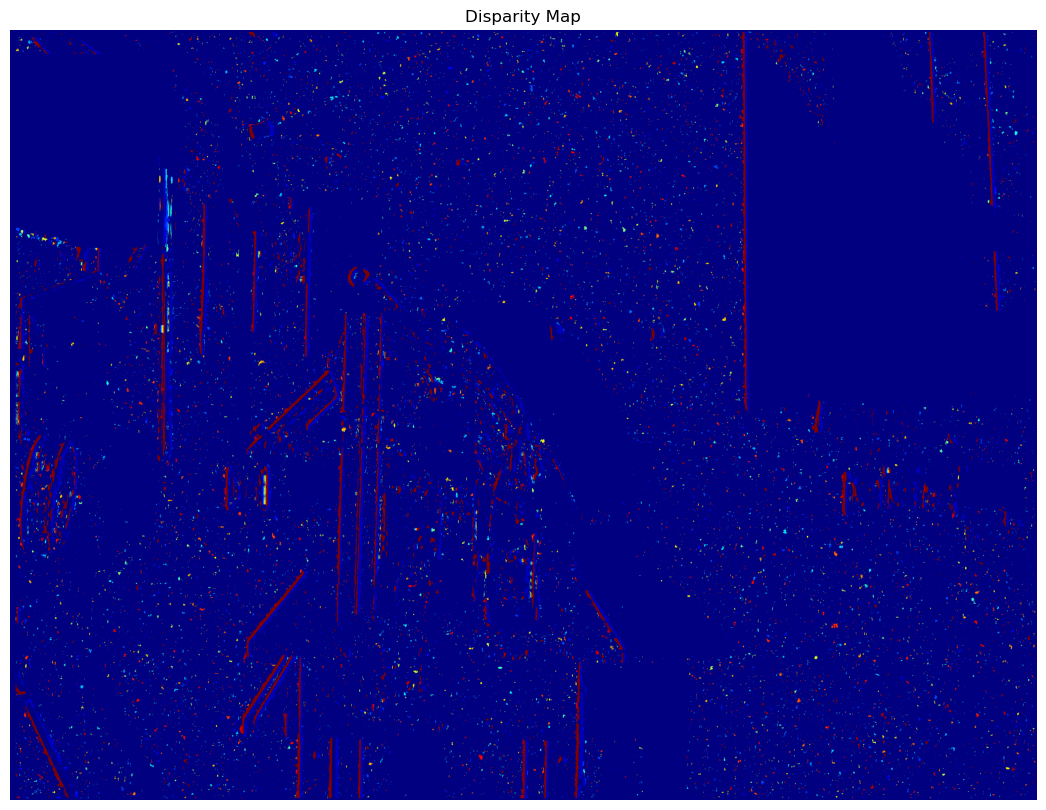

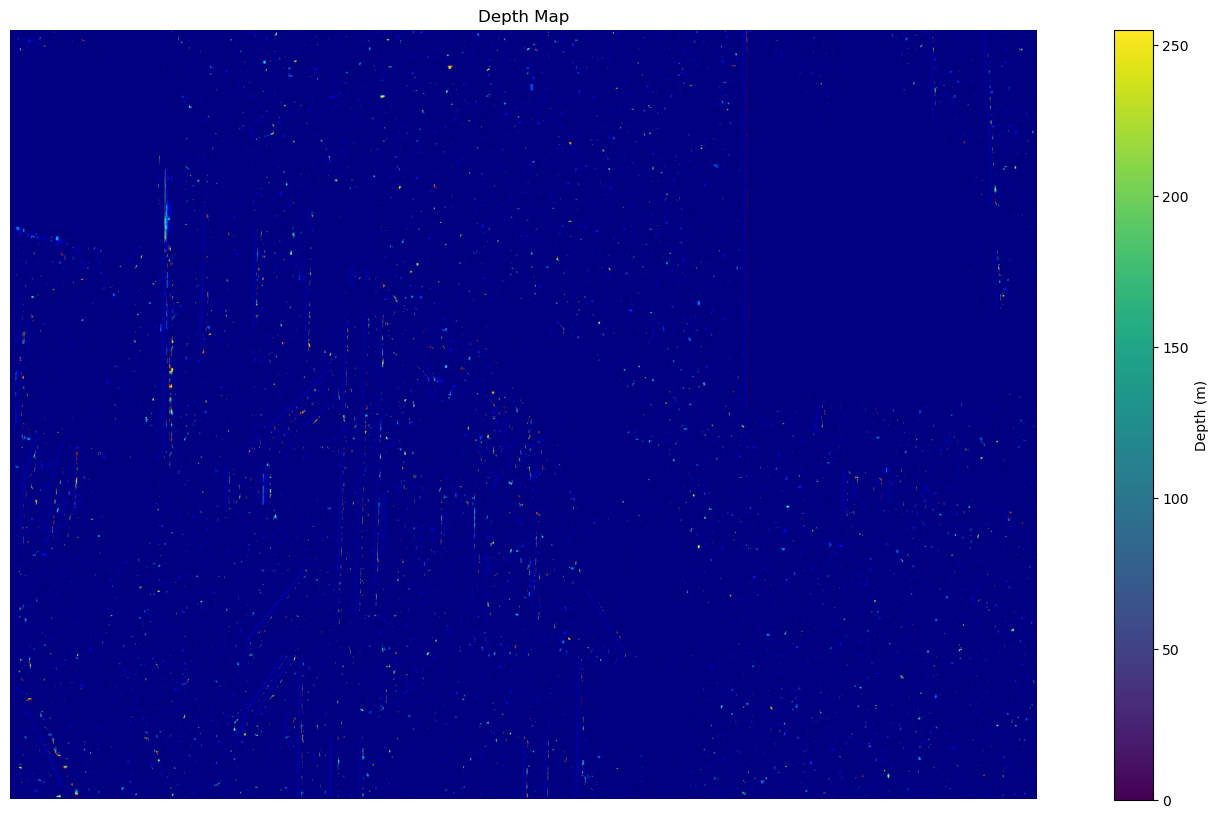

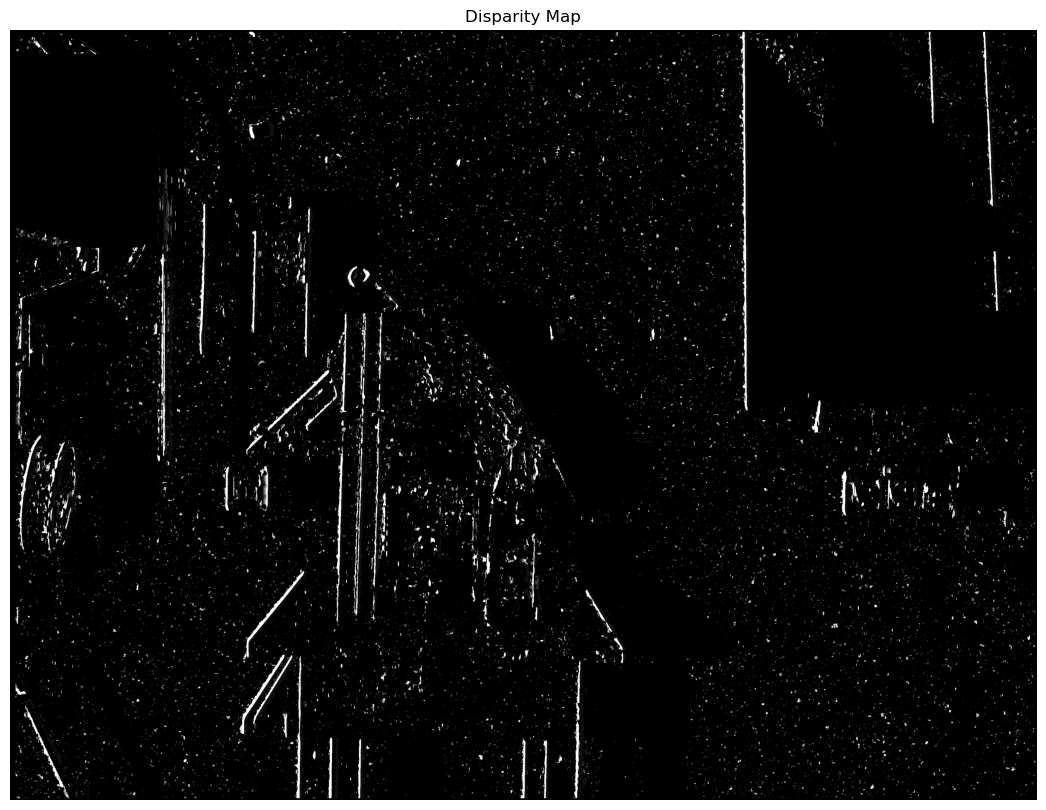

In [10]:
# StereoBM Konfiguration
stereo = cv.StereoBM_create(numDisparities=16, blockSize=15)
disparity = stereo.compute(imgL, imgR)

# Baseline (Abstand zwischen den Kameras) und Brennweite der Kamera
baseline = 60  # Beispielwert, bitte anpassen
focal_length = 12  # Beispielwert, bitte anpassen

# Normalisieren der Disparitätskarte für die Anzeige
min_disp = disparity.min()
max_disp = disparity.max()
disparity_normalized = np.uint8(255 * (disparity - min_disp) / (max_disp - min_disp))

# Konvertieren der Disparitätskarte in eine Tiefenkarte
depth_map = np.zeros(disparity.shape, dtype=np.float32)
valid_pixels = disparity > 0
depth_map[valid_pixels] = (baseline * focal_length) / disparity[valid_pixels]

# Normalisieren der Tiefenkarte
depth_normalized = cv.normalize(depth_map, None, alpha=0, beta=1, norm_type=cv.NORM_MINMAX, dtype=cv.CV_32F)

# Umwandeln der Disparitätskarte in eine Farbkarte
disparity_color = cv.applyColorMap(disparity_normalized, cv.COLORMAP_JET)
depth_color = cv.applyColorMap((depth_normalized * 255).astype(np.uint8), cv.COLORMAP_JET)

# Anzeigen der Disparitätskarte mit Matplotlib
plt.figure(figsize=(20, 10))
plt.imshow(cv.cvtColor(disparity_color, cv.COLOR_BGR2RGB))
plt.title('Disparity Map')
plt.axis('off')
plt.show()

# Anzeigen der Tiefenkarte mit Matplotlib
plt.figure(figsize=(20, 10))
plt.imshow(cv.cvtColor(depth_color, cv.COLOR_BGR2RGB))
plt.colorbar(label='Depth (m)')
plt.title('Depth Map')
plt.axis('off')
plt.show()

plt.figure(figsize=(20, 10))
plt.imshow(disparity_normalized, cmap='gray')
plt.title('Disparity Map')
plt.axis('off')
plt.show()

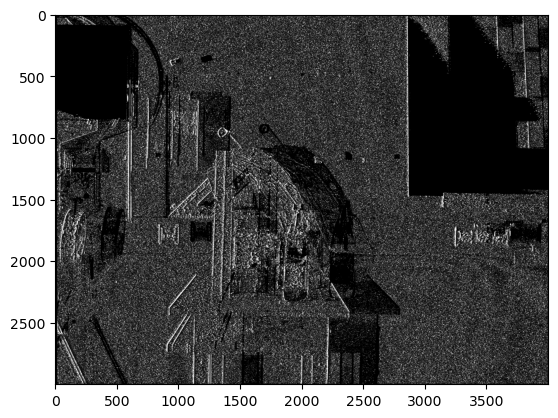

In [11]:
stereo = cv.StereoBM.create(numDisparities=16, blockSize=5)
disparity = stereo.compute(imgL,imgR)
plt.imshow(disparity,'gray')
plt.show()

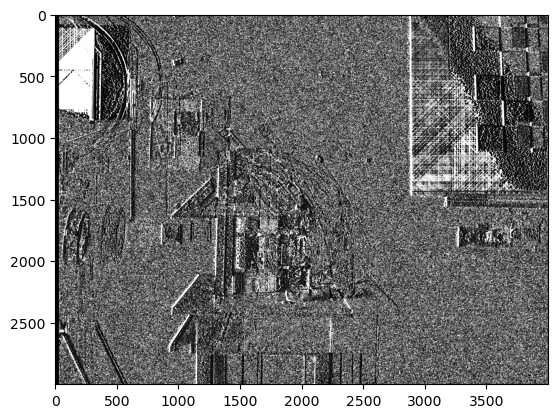

In [12]:
stereo = cv.StereoSGBM.create(minDisparity=16, numDisparities=16, blockSize=5)
disparity = stereo.compute(imgL,imgR)
plt.imshow(disparity,'gray')
plt.show()

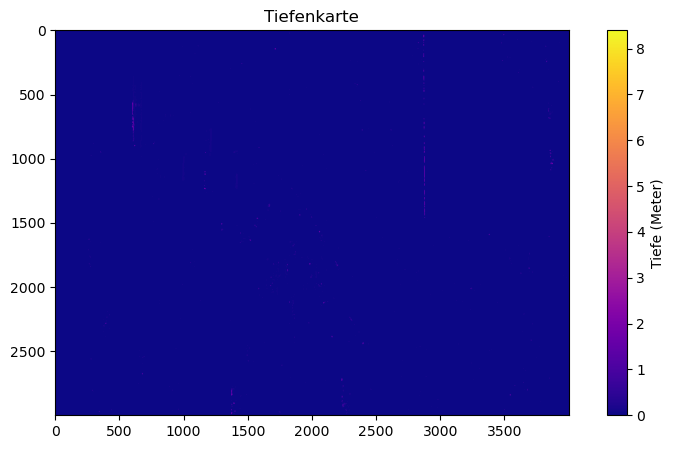

In [13]:
# Initialisiere den StereoBM-Algorithmus
stereo = cv.StereoBM_create(numDisparities=16*16, blockSize=15)

# Berechne die Disparität
disparity = stereo.compute(imgL, imgR).astype(np.float32) / 16.0

# Kameraparameter (Beispielwerte, müssen kalibriert werden)
focal_length = 70  # Brennweite in Pixeln
baseline = 0.06       # Stereobasis in Metern

# Tiefenkarte berechnen
depth_map = (focal_length * baseline) / (disparity + 1e-5)  # Vermeidung von Division durch Null

# Maskiere ungültige Werte (Disparität <= 0)
depth_map[disparity <= 0] = 0

# Zeige das Ergebnis
plt.figure(figsize=(10, 5))
plt.imshow(depth_map, cmap='plasma')
plt.title('Tiefenkarte')
plt.colorbar(label='Tiefe (Meter)')
plt.show()

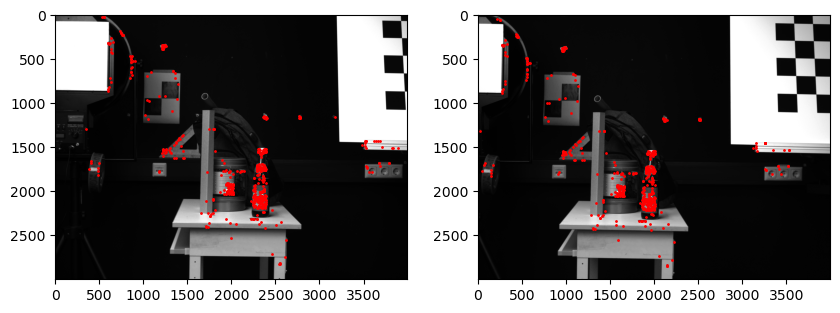

In [14]:
# Feature-Detektor und Matcher initialisieren
sift = cv.SIFT_create()
kp1, des1 = sift.detectAndCompute(imgL, None)
kp2, des2 = sift.detectAndCompute(imgR, None)

bf = cv.BFMatcher()
matches = bf.knnMatch(des1, des2, k=2)

# Nur gute Matches behalten
good_matches = []
for m, n in matches:
    if m.distance < 0.75 * n.distance:
        good_matches.append(m)

# Extrahiere Punktpaare
pts1 = np.float32([kp1[m.queryIdx].pt for m in good_matches])
pts2 = np.float32([kp2[m.trainIdx].pt for m in good_matches])

# Berechnung der Fundamental-Matrix
F, mask = cv.findFundamentalMat(pts1, pts2, cv.FM_RANSAC)

# Auswahl nur der inlier points
pts1 = pts1[mask.ravel() == 1]
pts2 = pts2[mask.ravel() == 1]

# Tiefenberechnung hier einfügen (hier ist nur ein rudimentäres Beispiel)
# Weitere Schritte notwendig für vollständige SfM

plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.imshow(imgL, cmap='gray')
plt.scatter(pts1[:, 0], pts1[:, 1], color='r', s=1)
plt.subplot(1, 2, 2)
plt.imshow(imgR, cmap='gray')
plt.scatter(pts2[:, 0], pts2[:, 1], color='r', s=1)
plt.show()

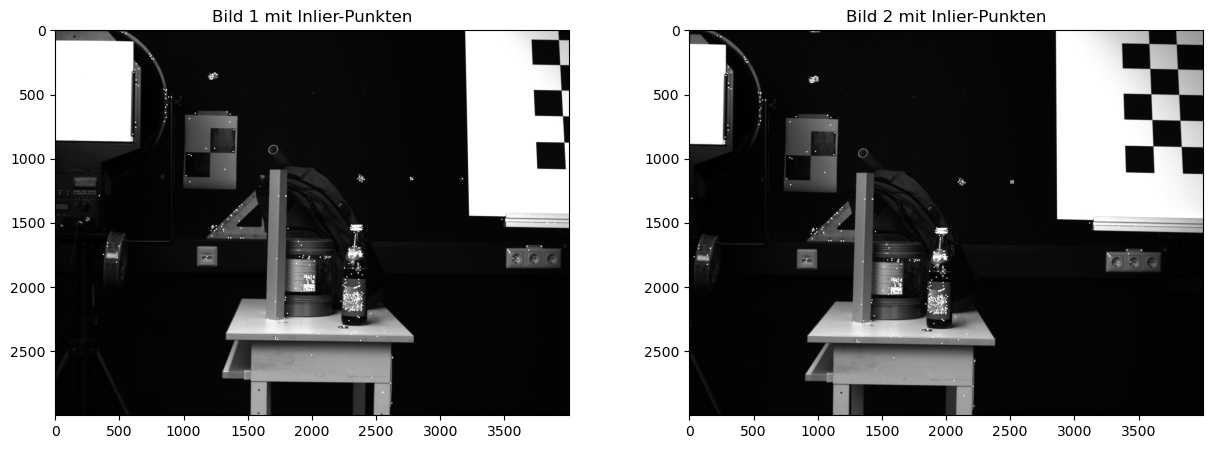

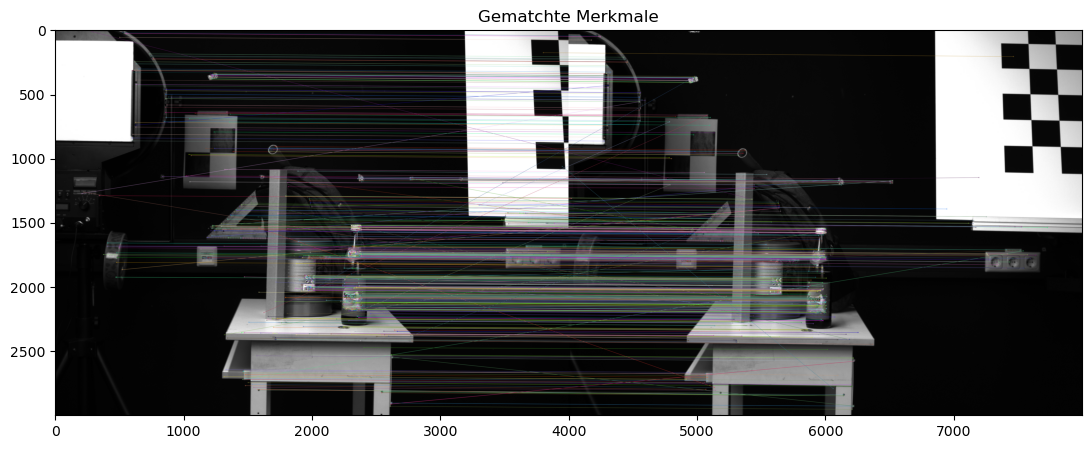

In [15]:
# Feature-Detektor (SIFT) und -Beschreiber initialisieren
sift = cv.SIFT_create()

# Merkmale und Beschreibungen berechnen
kp1, des1 = sift.detectAndCompute(imgL, None)
kp2, des2 = sift.detectAndCompute(imgR, None)

# Brute-Force-Matcher initialisieren
bf = cv.BFMatcher()

# Merkmale matchen
matches = bf.knnMatch(des1, des2, k=2)

# Nur die besten Matches behalten (Lowe's ratio test)
good_matches = []
for m, n in matches:
    if m.distance < 0.75 * n.distance:
        good_matches.append(m)

# Extrahiere die Punktpaare
pts1 = np.float32([kp1[m.queryIdx].pt for m in good_matches])
pts2 = np.float32([kp2[m.trainIdx].pt for m in good_matches])

# Berechne die Fundamental-Matrix
F, mask = cv.findFundamentalMat(pts1, pts2, cv.FM_RANSAC)

# Filtere nur die Inlier-Punkte heraus
pts1_inliers = pts1[mask.ravel() == 1]
pts2_inliers = pts2[mask.ravel() == 1]

# Visualisiere die Matches
img_matches = cv.drawMatches(imgL, kp1, imgR, kp2, good_matches, None, flags=cv.DrawMatchesFlags_NOT_DRAW_SINGLE_POINTS)

# Zeichne die Inlier-Punkte auf den Bildern
for pt in pts1_inliers:
    cv.circle(imgL, (int(pt[0]), int(pt[1])), 5, (255, 0, 0), -1)
for pt in pts2_inliers:
    cv.circle(imgR, (int(pt[0]), int(pt[1])), 5, (255, 0, 0), -1)

# Zeige die Ergebnisse
plt.figure(figsize=(15, 5))
plt.subplot(1, 2, 1)
plt.imshow(imgL, cmap='gray')
plt.title('Bild 1 mit Inlier-Punkten')
plt.subplot(1, 2, 2)
plt.imshow(imgR, cmap='gray')
plt.title('Bild 2 mit Inlier-Punkten')
plt.show()

plt.figure(figsize=(15, 5))
plt.imshow(img_matches)
plt.title('Gematchte Merkmale')
plt.show()

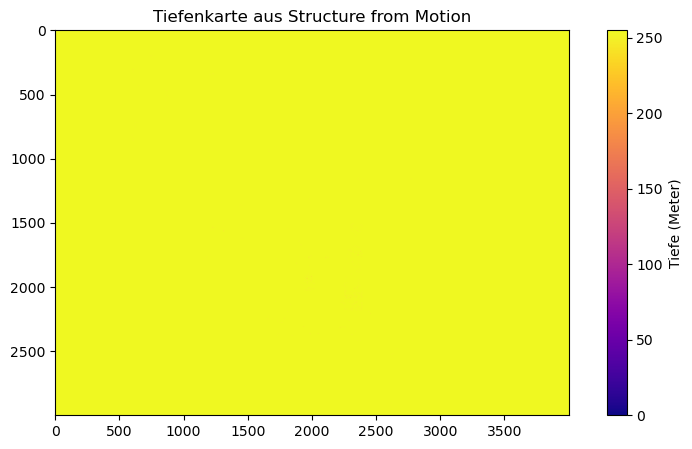

In [16]:
# Feature-Detektor (SIFT) und -Beschreiber initialisieren
sift = cv.SIFT_create()

# Merkmale und Beschreibungen berechnen
kpL, desL = sift.detectAndCompute(imgL, None)
kpR, desR = sift.detectAndCompute(imgR, None)

# Brute-Force-Matcher initialisieren
bf = cv.BFMatcher()

# Merkmale matchen
matches = bf.knnMatch(desL, desR, k=2)

# Lowe's Ratio Test, um nur die besten Matches zu behalten
good_matches = []
for m, n in matches:
    if m.distance < 0.75 * n.distance:
        good_matches.append(m)

# Extrahiere die Punktpaare
ptsL = np.float32([kpL[m.queryIdx].pt for m in good_matches])
ptsR = np.float32([kpR[m.trainIdx].pt for m in good_matches])

# Berechne die Fundamental-Matrix
F, mask = cv.findFundamentalMat(ptsL, ptsR, cv.FM_RANSAC)

# Filtere nur die Inlier-Punkte heraus
ptsL = ptsL[mask.ravel() == 1]
ptsR = ptsR[mask.ravel() == 1]

# Intrinsische Kameraparameter (angenommen oder aus Kalibrierung)
K = np.array([[1000, 0, imgL.shape[1]/2],
              [0, 1000, imgL.shape[0]/2],
              [0, 0, 1]])

# Essential Matrix aus Fundamental Matrix und Intrinsischen Parametern berechnen
E = K.T @ F @ K

# Dekomposition der Essential Matrix, um R und t zu erhalten
_, R, t, _ = cv.recoverPose(E, ptsL, ptsR, K)

# Baseline (Abstand zwischen den Kameras)
baseline = np.linalg.norm(t)

# Berechne Tiefeninformation für jeden Punkt
depth_map = np.zeros_like(imgL, dtype=np.float32)

# Iteriere über alle Punkte
for i in range(len(ptsL)):
    # Punkt-Koordinaten in Bild 1 und Bild 2
    ptL = ptsL[i]
    ptR = ptsR[i]
    
    # Triangulation der Punkte
    A = np.array([
        [ptL[0], 1],
        [ptR[0], 1]
    ])
    B = np.array([
        [ptL[1]],
        [ptR[1]]
    ])
    
    # Berechne die Tiefe (Tiefenkarte)
    depth = baseline / np.dot(np.linalg.inv(A), B)[0, 0]
    
    # Speichere die Tiefe im Depth-Map-Array
    depth_map[int(ptL[1]), int(ptL[0])] = depth

# Normalisiere die Tiefenkarte für die Darstellung
depth_map = cv.normalize(depth_map, None, alpha=0, beta=255, norm_type=cv.NORM_MINMAX)
depth_map = np.uint8(depth_map)

# Zeige die Tiefenkarte an
plt.figure(figsize=(10, 5))
plt.imshow(depth_map, cmap='plasma')
plt.colorbar(label='Tiefe (Meter)')
plt.title('Tiefenkarte aus Structure from Motion')
plt.show()

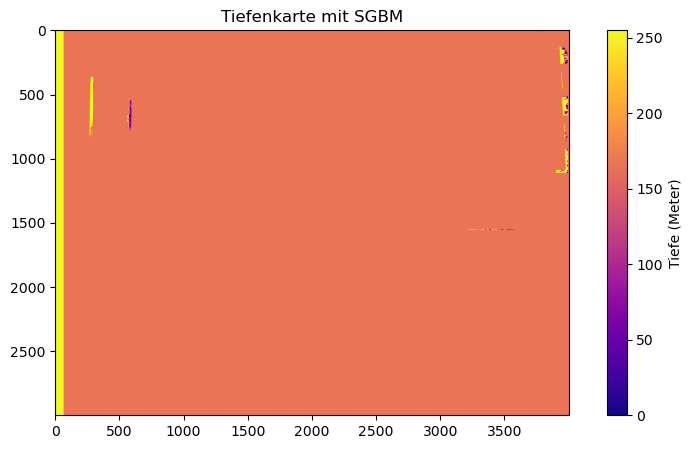

In [17]:
# SGBM-Disparitätsberechnung
#stereo = cv.StereoSGBM_create(minDisparity=3,
#                               numDisparities=128,  # Mehr Disparitäten für detailliertere Tiefenkarte
#                               blockSize=21,  # Größerer Block für genauere Disparitätsberechnung
#                               P1=200,  # Erhöhte Glättungskosten für eine glattere Oberfläche
#                               P2=800,  # Erhöhte Glättungskosten für eine glattere Oberfläche
#                               preFilterCap=63,  # Vorfilterungskappe für die Disparitäten
#                               uniquenessRatio=10)  # Einschränkung der Uniqueness-Constraint


# SGBM-Parameter einstellen
minDisparity = 3
numDisparities = 64  # Muss durch 16 teilbar sein
blockSize = 21  # Ungerade Zahl, typischerweise zwischen 3 und 11
P1 = 8 * 3 * blockSize ** 2
P2 = 32 * 3 * blockSize ** 2
disp12MaxDiff = 1  # Maximale Differenz in der Disparitätswerte zwischen benachbarten Pixeln
preFilterCap = 63  # Begrenzung der Vorfilterung der Disparitäten
uniquenessRatio = 10  # Maximale Unähnlichkeitsrate zwischen den besten und zweitbesten Disparitätskosten
speckleWindowSize = 100  # Maximale Größe des Bereichs, in dem die Disparitäten als Speckle betrachtet werden
speckleRange = 32  # Maximale Differenz zwischen den Disparitäten innerhalb eines zusammenhängenden Bereichs, um als Speckle betrachtet zu werden
mode = cv.StereoSGBM_MODE_SGBM  # Modus für die Disparitätsberechnung

# SGBM-Objekt erstellen
stereo = cv.StereoSGBM_create(minDisparity=minDisparity,
                               numDisparities=numDisparities,
                               blockSize=blockSize,
                               P1=P1,
                               P2=P2,
                               disp12MaxDiff=disp12MaxDiff,
                               preFilterCap=preFilterCap,
                               uniquenessRatio=uniquenessRatio,
                               speckleWindowSize=speckleWindowSize,
                               speckleRange=speckleRange,
                               mode=mode)

disparity = stereo.compute(imgL, imgR).astype(np.float32) / 16.0

# Umwandlung der Disparität in eine Tiefenkarte
baseline = 0.006  # Beispiel für die Baseline in Metern
depth_map = baseline / disparity

# Normalisierung der Tiefenkarte für die Darstellung
depth_map = cv.normalize(depth_map, None, alpha=0, beta=255, norm_type=cv.NORM_MINMAX)
depth_map = np.uint8(depth_map)

# Anzeigen der Tiefenkarte
plt.figure(figsize=(10, 5))
plt.imshow(depth_map, cmap='plasma')
plt.colorbar(label='Tiefe (Meter)')
plt.title('Tiefenkarte mit SGBM')
plt.show()

In [6]:
import cv2
import numpy as np

def compute_depth_map(img_left_path, img_right_path, baseline, focal_length, orig_width, target_width):
    # Bilder einlesen
    img_left = cv2.imread(img_left_path, cv2.IMREAD_GRAYSCALE)
    img_right = cv2.imread(img_right_path, cv2.IMREAD_GRAYSCALE)
    
    # Bildgröße anpassen
    img_left_resized = cv2.resize(img_left, (target_width, int(img_left.shape[0] * target_width / img_left.shape[1])))
    img_right_resized = cv2.resize(img_right, (target_width, int(img_right.shape[0] * target_width / img_right.shape[1])))
    
    # StereoBM-Objekt erstellen und die Parameter einstellen
    stereo = cv2.StereoBM_create(numDisparities=16, blockSize=15)
    
    # Disparitätskarte berechnen
    disparity = stereo.compute(img_left_resized, img_right_resized).astype(np.float32) / 16.0
    
    # Verhältnis berechnen
    scale_factor = target_width / orig_width
    
    # Neue Brennweite berechnen
    focal_length_scaled = focal_length * scale_factor
    
    # Konvertiere die Disparitätskarte in eine Tiefenkarte
    disparity[disparity == 0] = 0.1  # Vermeidung von Division durch Null
    disparity[disparity == -1] = 0.1  # Vermeidung von Division durch -1
    
    depth_map = (focal_length_scaled * baseline) / disparity
    
    # Normiere die Tiefenkarte zum besseren Anzeigen
    depth_map_normalized = cv2.normalize(depth_map, None, 0, 255, cv2.NORM_MINMAX)
    depth_map_normalized = np.uint8(depth_map_normalized)
    
    return depth_map_normalized

# Parameter der Stereobasis und Brennweite (in Pixel)
baseline = 0.54  # Beispielwert in Meter, anpassen an Ihre Stereobasis
focal_length_pixels = 3888.89  # Beispielwert in Pixel, berechnet aus dem vorherigen Schritt
orig_width = 4000
target_width = 1920

# Dateipfade der linken und rechten Bilder
img_left_path = 'Utils/Images/test/LINKS_V3.png'
img_right_path = 'Utils/Images/test/RECHTS_V3.png'

# Tiefenkarte berechnen
depth_map = compute_depth_map(img_left_path, img_right_path, baseline, focal_length_pixels, orig_width, target_width)

# Tiefenkarte anzeigen
cv2.imshow('Depth Map', depth_map)
cv2.waitKey(0)
cv2.destroyAllWindows()



Erkannte Linien: 566


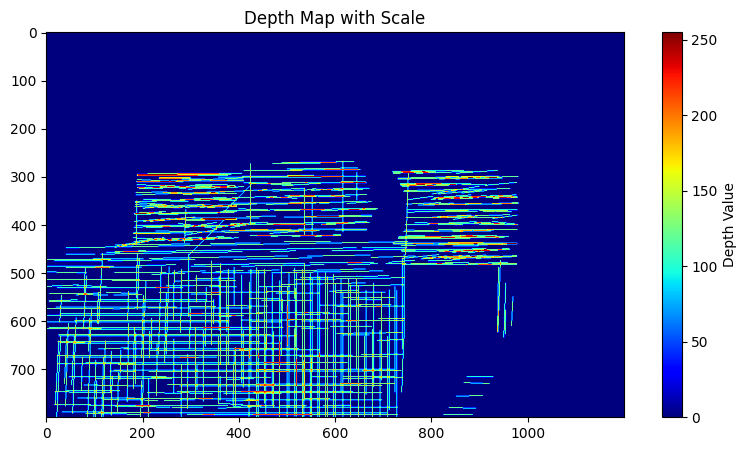

In [16]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

def create_depth_map(grid_image_path):
    # Bild laden
    img = cv2.imread(grid_image_path)
    
    # Überprüfen, ob das Bild geladen wurde
    if img is None:
        raise ValueError(f"Bild {grid_image_path} konnte nicht geladen werden.")
    
    # Bild auf 1200x800 skalieren
    img_resized = cv2.resize(img, (1200, 800), interpolation=cv2.INTER_LINEAR)
    
    # Roten Kanal extrahieren
    red_channel = img_resized[:, :, 2]
    
    # Bildgröße erhalten
    height, width = red_channel.shape
    
    # Canny-Kantendetektion anwenden, um die Gitterlinien im roten Kanal zu erkennen
    edges = cv2.Canny(red_channel, 50, 150, apertureSize=3)
    
    # Zeige die Kanten zum Debuggen an
    cv2.imshow('Edges', edges)
    cv2.waitKey(0)
    
    # Hough-Transformation anwenden, um Linien im Bild zu finden
    lines = cv2.HoughLinesP(edges, 1, np.pi / 180, 100, minLineLength=50, maxLineGap=10)
    
    # Tiefenkarte initialisieren
    depth_map = np.zeros((height, width), dtype=np.float32)
    
    # Wenn Linien erkannt wurden
    if lines is not None:
        print(f"Erkannte Linien: {len(lines)}")
        for line in lines:
            x1, y1, x2, y2 = line[0]
            # Berechne die Linie
            cv2.line(depth_map, (x1, y1), (x2, y2), 255, 1)
    else:
        print("Keine Linien erkannt.")
    
    # Tiefenkarte normalisieren
    depth_map = cv2.normalize(depth_map, None, 0, 255, cv2.NORM_MINMAX)
    
    # Tiefenkarte als 8-Bit-Bild speichern
    depth_map = depth_map.astype(np.uint8)
    
    return depth_map

def display_depth_map_with_scale(depth_map):
    plt.figure(figsize=(10, 5))
    plt.imshow(depth_map, cmap='jet')
    plt.colorbar(label='Depth Value')
    plt.title('Depth Map with Scale')
    plt.show()

# Beispielaufruf
grid_image_path = '../../02_Utils/Images/lasertestv2-rechts2.png'
depth_map = create_depth_map(grid_image_path)

# Tiefenkarte anzeigen mit Skala
display_depth_map_with_scale(depth_map)

In [ ]:
grid_image_path = '../../02_Utils/Images/lasertestv2-rechts.png'

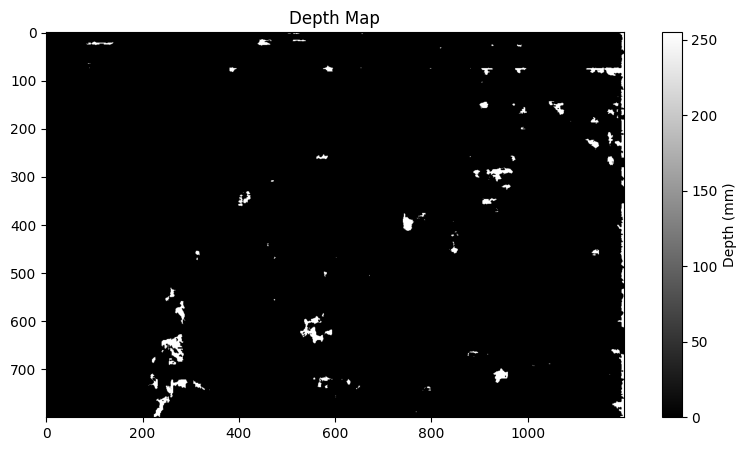

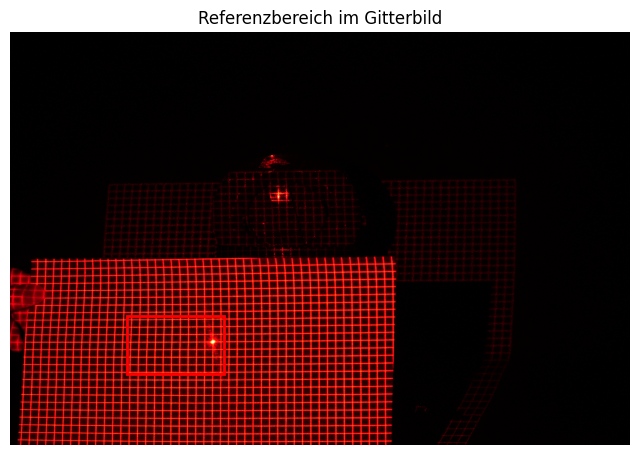

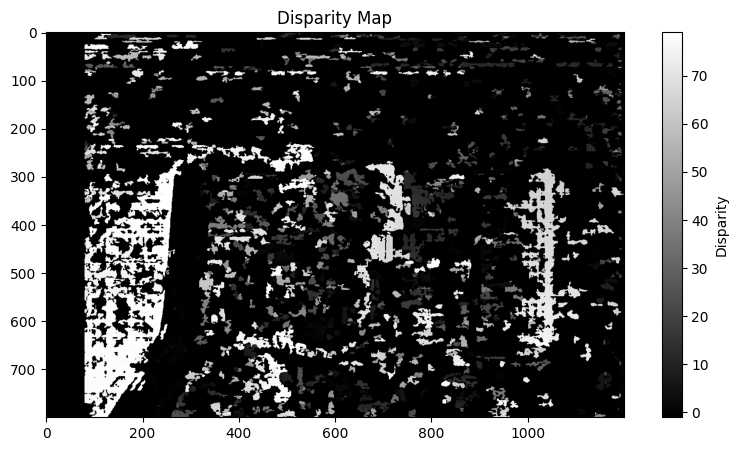

In [25]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

def load_and_preprocess_images(left_image_path, right_image_path, grid_image_path):
    # Bilder laden
    img_left = cv2.imread(left_image_path, cv2.IMREAD_GRAYSCALE)
    img_right = cv2.imread(right_image_path, cv2.IMREAD_GRAYSCALE)
    img_grid = cv2.imread(grid_image_path)
    
    # Überprüfen, ob die Bilder geladen wurden
    if img_left is None or img_right is None or img_grid is None:
        raise ValueError("Ein oder mehrere Bilder konnten nicht geladen werden.")
    
    # Bilder auf 1200x800 skalieren
    img_left_resized = cv2.resize(img_left, (1200, 800), interpolation=cv2.INTER_LINEAR)
    img_right_resized = cv2.resize(img_right, (1200, 800), interpolation=cv2.INTER_LINEAR)
    img_grid_resized = cv2.resize(img_grid, (1200, 800), interpolation=cv2.INTER_LINEAR)
    
    return img_left_resized, img_right_resized, img_grid_resized

def compute_disparity_map(img_left, img_right):
    # Stereo-SGBM Matcher erstellen
    stereo = cv2.StereoSGBM_create(minDisparity=0,
                                   numDisparities=16 * 5,  # multiple of 16
                                   blockSize=9,
                                   P1=8 * 3 * 3 ** 2,
                                   P2=32 * 3 * 3 ** 2,
                                   disp12MaxDiff=1,
                                   uniquenessRatio=15,
                                   speckleWindowSize=100,
                                   speckleRange=32)
    
    # Disparitätskarte berechnen
    disparity_map = stereo.compute(img_left, img_right).astype(np.float32) / 16.0
    
    return disparity_map

def find_reference_region(grid_image):
    # Roten Kanal extrahieren (Annahme: Gittermuster ist im roten Kanal codiert)
    red_channel = grid_image[:, :, 2]
    
    # Canny-Kantendetektion anwenden, um die Gitterlinien im roten Kanal zu erkennen
    edges = cv2.Canny(red_channel, 50, 150, apertureSize=3)
    
    # Konturen finden
    contours, _ = cv2.findContours(edges, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    
    # Nach der größten Kontur suchen (Annahme: das gesuchte Muster)
    if contours:
        contour = max(contours, key=cv2.contourArea)
        # Bounding Box der Kontur
        x, y, w, h = cv2.boundingRect(contour)
        
        # Unteren linken Punkt der Bounding Box als Referenzpunkt wählen
        reference_center_x = x
        reference_center_y = y + int(2.5 * h)  # Höhe um den Faktor 2.5 vergrößern
        reference_width = w
        reference_height = h
        
        return reference_center_x, reference_center_y, reference_width, reference_height
    
    return None

def calculate_distance_to_reference(reference_center_y):
    # Annahme: Der untere linke Viertel des Bildes ist der Referenzpunkt (800 mm)
    reference_distance = reference_center_y - 0  # Hier ggf. die tatsächliche Position anpassen
    return reference_distance

def create_depth_map(disparity_map, reference_distance):
    # Tiefenkarte basierend auf der Disparität und dem Referenzabstand erstellen
    depth_map = np.zeros_like(disparity_map, dtype=np.float32)
    
    # Faktor für die Umrechnung der Disparität in Tiefe (Annahme: 1 Pixel entspricht 1 mm)
    conversion_factor = 1.0
    
    # Tiefe berechnen
    depth_map = reference_distance * conversion_factor / (disparity_map + 1e-6)
    
    # Tiefenkarte normalisieren (optional)
    depth_map_normalized = cv2.normalize(depth_map, None, 0, 255, cv2.NORM_MINMAX)
    depth_map_normalized = depth_map_normalized.astype(np.uint8)
    
    return depth_map_normalized

def display_depth_map(depth_map):
    plt.figure(figsize=(10, 5))
    plt.imshow(depth_map, cmap='gray')
    plt.colorbar(label='Depth (mm)')
    plt.title('Depth Map')
    plt.show()

# Beispielaufruf
left_image_path = '../../02_Utils/Images/lasertestv2-links.png'
right_image_path = '../../02_Utils/Images/lasertestv2-rechts.png'
grid_image_path = '../../02_Utils/Images/lasertestv2-rechts2.png'

img_left, img_right, img_grid = load_and_preprocess_images(left_image_path, right_image_path, grid_image_path)

# Referenzbereich im Gitterbild finden
reference_center_x, reference_center_y, reference_width, reference_height = find_reference_region(img_grid)
if reference_center_x is None:
    raise ValueError("Der Referenzbereich im Gitterbild konnte nicht gefunden werden.")

# Abstand zum Referenzmuster berechnen
reference_distance = calculate_distance_to_reference(reference_center_y)

# Disparitätskarte berechnen
disparity_map = compute_disparity_map(img_left, img_right)

# Tiefenkarte erstellen
depth_map = create_depth_map(disparity_map, reference_distance)

# Tiefenkarte anzeigen
display_depth_map(depth_map)

# Visualisierung des Referenzbereichs im Gitterbild (für Debugging-Zwecke)
plt.figure(figsize=(8, 6))
plt.imshow(cv2.cvtColor(img_grid, cv2.COLOR_BGR2RGB))
plt.gca().add_patch(plt.Rectangle((reference_center_x - reference_width // 2, reference_center_y - reference_height // 2),
                                  reference_width, reference_height, edgecolor='r', facecolor='none', linewidth=2))
plt.title('Referenzbereich im Gitterbild')
plt.axis('off')
plt.show()

# Optional: Anzeige der Disparitätskarte (für Debugging-Zwecke)
plt.figure(figsize=(10, 5))
plt.imshow(disparity_map, cmap='gray')
plt.colorbar(label='Disparity')
plt.title('Disparity Map')
plt.show()